In [1]:
import os
import glob
import pydicom
import math
import cv2
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from PIL import Image as im
from typing import Tuple
from pydicom import dcmread
from skimage import exposure
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.morphology import binary_erosion
from matplotlib.pyplot import show,imshow
from keras.models import load_model
from scipy.ndimage.measurements import label

In [2]:
incoming = r'N:\2_Analysis\automated_analysis\AWS_pipeline\incoming'
outgoing = r'N:\2_Analysis\automated_analysis\AWS_pipeline\outgoing'

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def erode_liver_3D(liver_array, voxel_dimensions):
    radius = 5
    x_dim = voxel_dimensions[0]
    y_dim = voxel_dimensions[1]
    z_dim = voxel_dimensions[2]
    kernel = np.zeros((2*int(math.ceil(radius/x_dim))+1, 2*int(math.ceil(radius/y_dim))+1, 2*int(math.ceil(radius/z_dim))+1))
    x,y,z = np.ogrid[-int(math.ceil(radius/x_dim)):int(math.ceil(radius/x_dim))+1, -int(math.ceil(radius/y_dim)):int(math.ceil(radius/y_dim))+1,-int(math.ceil(radius/z_dim)):int(math.ceil(radius/z_dim))+1]
    mask = ((x*x_dim)**2 + (y*y_dim)**2) + (z*z_dim)**2 <= radius**2
    kernel[mask] = 1
    eroded_liver = binary_erosion(liver_array, structure = kernel)
    return eroded_liver


def get_mean(array):
    if array.size != 0: return array.mean()
    else: return math.nan


def get_std(array):
    if array.size != 0: return array.std()
    else: return math.nan


def normalizeImageIntensityRange(img):
    HOUNSFIELD_MIN = np.min(img)
    HOUNSFIELD_MAX = np.max(img)
    HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE
 
    
def load_segseg_model(model_seg_dir, weights_dir):
    json_file = open(model_seg_dir, 'r'); loaded_model_json = json_file.read(); json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights(weights_dir) # Load model weights
    return model


def normalize_image(img,low_p=0,up_p=100):
    """ Normalize image values to [0,1] """
    min_ = np.percentile(img.flatten(),low_p)
    max_ = np.percentile(img.flatten(),up_p)
    if min_ == max_ and max_ > 0:
        return (img - min_) / (max_ - min_)
    elif min_ == max_ and max_ == 0:
        return img
    else:
        new_img  = (img - min_) / (max_ - min_)
        new_img[new_img > 1] = 1
        new_img[new_img < 0] = 0

        return new_img

    
def process_mask(arr, out_shape):
    liv = arr[:,:,:,0]
    liv = zoom(liv, (out_shape[0]/192, out_shape[1]/192, out_shape[2]/96))
    liv[liv >= 0.5] = 1; liv[liv < 0.5] = 0
    liv = largestConnectedComponent(liv)
    arr_resize = np.zeros((out_shape[0], out_shape[1], out_shape[2], 10))
    for ii in range(arr.shape[-1]):
        arr_resize[:,:,:,ii] = zoom(arr[:,:,:,ii], (out_shape[0]/192, out_shape[1]/192, out_shape[2]/96))
    arr_resize[arr_resize <= 0.5] = 0.
    arr = np.argmax(np.concatenate([ np.zeros((out_shape[0], out_shape[1], out_shape[2],1)), arr_resize[:,:,:,1:] ], -1), axis=-1)
    arr_resize = np.zeros((out_shape[0], out_shape[1], out_shape[2], 9))
    for ii in range(9):
        arr_resize[:,:,:,ii][np.where(arr == (ii+1))] = 1
        arr_resize[:,:,:,ii] = largestConnectedComponent(arr_resize[:,:,:,ii])
    arr = np.argmax(np.concatenate([ np.zeros((out_shape[0], out_shape[1], out_shape[2],1)), arr_resize ], -1), axis=-1)
    return liv,arr


def dcm_to_ni(dicoms_list):
    dicoms_list.sort()
    dcm = pydicom.read_file(dicoms_list[0])
    nx,ny = dcm.pixel_array.shape; nz = len(dicoms_list)
    dx,dy = [float(i) for i in dcm.PixelSpacing]
    try:
        dz = float(dcm.SpacingBetweenSlices)
    except:
        dz = float(dcm.SliceThickness)
    affine = np.diag([dx,dy,dz,1])
    np_array = np.zeros((nz,nx,ny), dtype = 'float32')
    for dcm_path in dicoms_list:
        dcm = pydicom.read_file(dcm_path)
        np_array[dicoms_list.index(dcm_path), :, :] = dcm.pixel_array

    np_array = np.flip(np.flip(np.swapaxes(np_array, 0, 2),0),1)
    
    dcm1_sl = float(pydicom.read_file(dicoms_list[0]).SliceLocation)
    dcm2_sl = float(pydicom.read_file(dicoms_list[1]).SliceLocation)
    if dcm1_sl > dcm2_sl: np_array = np.flip(np_array, axis =2)
    
    ni_obj = nib.Nifti1Image(np_array, affine)
    
    return ni_obj


def largestConnectedComponent(cnn_seg):
    cnn_seg[cnn_seg >= 0.5] = 1; cnn_seg[cnn_seg < 0.5] = 0
    struct = np.ones((3,3,3))
    pred_postp1 = cnn_seg
    labels, num_features = label(pred_postp1,struct)
    if num_features !=0:
        feature_size = np.zeros((num_features,))
        for ii in range(num_features):
            feature_size[ii] = np.sum(labels==(ii+1))
            label_liver = np.argmax(feature_size)
            pred_postp = np.zeros(cnn_seg.shape)
            pred_postp[labels== (label_liver+1)] = 1
    else:
        pred_postp = cnn_seg
    return pred_postp
 
    
def get_all_paths(study_folder):
    paths=[]
    for path in os.listdir(study_folder):
        rpath = os.path.join(study_folder, path)
        paths.append(rpath)
    return paths


def get_dicom(study_folder):
    paths=[]
    for path in os.listdir(study_folder):
        rpath = path
        paths.append(rpath)
    return paths


def get_series(study_folder):
    paths=[]
    for path in os.listdir(study_folder):
        rpath = path[:7]
        paths.append(rpath)
    return paths

def overlay(
    image: np.ndarray,
    mask: np.ndarray,
    color: Tuple[int, int, int] = (255, 0, 0),
    alpha: float = 0.5, 
    resize: Tuple[int, int] = (256, 256)
) -> np.ndarray:
    """
    Params:
        image: Training image.
        mask: Segmentation mask.
        color: Color for segmentation mask rendering.
        alpha: Segmentation mask's transparency.
        resize: If provided, both image and its mask are resized before blending them together.
    """
    color = np.asarray(color).reshape(3, 1, 1)
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()
    
    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)
    
    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    
    return image_combined

In [4]:
model_dir = 'segmental_segmentation_model.hdf5' 
weight_dir = 'segmental_segmentation_weights.hdf5' 
spleen_model_dir = 'V5_2D_UNET_LIG_IDEAL_first20_L7_H256_W256.h5'

model = load_segseg_model(model_dir, weight_dir)
spleen_model = load_model(spleen_model_dir, custom_objects={'dice_coef':dice_coef,'dice_coef_loss':dice_coef_loss})

In [5]:
dicoms = get_dicom(incoming)
series = np.unique(np.array(get_series(incoming)))

series_0 = []
series_1 = []
series_2 = []

r2 = []
mag = []
ff = []

for i in dicoms:
    if i.startswith(series[0]):
        series_0.append(os.path.join(incoming, i))
    if i.startswith(series[1]):
        series_1.append(os.path.join(incoming, i))
    if i.startswith(series[2]):
        series_2.append(os.path.join(incoming, i))
        
series_0_dcm = dcmread(series_0[0])
series_1_dcm = dcmread(series_1[0])
series_2_dcm = dcmread(series_2[0])

s0_num = str(series_0_dcm.SeriesNumber)
s1_num = str(series_1_dcm.SeriesNumber)
s2_num = str(series_2_dcm.SeriesNumber)

if s0_num.endswith('00'):
    r2 = series_0
elif s0_num.endswith('01'):
    mag = series_0
else:
    ff = series_0

if s1_num.endswith('00'):
    r2 = series_1
elif s1_num.endswith('01'):
    mag = series_1
else:
    ff = series_1
    
if s2_num.endswith('00'):
    r2 = series_2
elif s2_num.endswith('01'):
    mag = series_2
else:
    ff = series_2

echo0 = np.rot90(np.flip(np.array((dcm_to_ni(mag)).get_fdata()),0))
ff0 = np.rot90(np.flip(np.array((dcm_to_ni(ff)).get_fdata()),0))
r20 = np.rot90(np.flip(np.array((dcm_to_ni(r2)).get_fdata()),0))

mag_level = np.zeros((echo0.shape[0], echo0.shape[1], echo0.shape[2]))

for i in range(echo0.shape[2]):
    img = echo0[:,:,i]
    p2, p98 = np.percentile(img, (2, 98))
    mag_level[:,:,i] = exposure.rescale_intensity(img, in_range=(p2, p98))

mag_ni = dcm_to_ni(mag)
image = normalize_image(mag_level)

In [6]:
''' Predict liver '''

s0,s1,s2 = echo0.shape
inp = zoom(echo0, (192/s0,192/s1,96/s2))
inp = np.expand_dims(np.expand_dims(normalize_image(inp, 0, 95), 0), -1)

pred = model.predict(inp)[0]

liver,seg = process_mask(pred, echo0.shape)

liver = np.swapaxes(liver,0,1)
liver = np.rot90(np.flip(liver,0),3)
seg = np.swapaxes(seg,0,1)
seg = np.rot90(np.flip(seg,0),3)
seg = seg.astype('int8')

In [7]:
''' Predict spleen '''

spleen = np.zeros((256, 256, echo0.shape[2]))

imgTarget = echo0
for i in range(imgTarget.shape[2]):
    img = imgTarget[:,:,i]
    img1 = np.expand_dims(np.expand_dims(normalize_image(img,0,100), 0), -1)
    pred2 = spleen_model.predict(img1)
    pred2[pred2 >= 0.5] = 1; pred2[pred2 < 0.5] =0
    pred2 = pred2[0, :, :, 0]
    spleen[:,:,i] = pred2

In [8]:
voxel_dimensions = (mag_ni.affine[0,0],mag_ni.affine[1,1],mag_ni.affine[2,2])

eroded_liver = erode_liver_3D(liver, voxel_dimensions)
eroded_spleen = erode_liver_3D(spleen, voxel_dimensions)

liv_ff = str(get_mean(ff0[eroded_liver == 1]))[:5]
liv_r2 = str(get_mean(r20[eroded_liver == 1]))[:5]
spleen_ff = str(get_mean(ff0[eroded_spleen == 1]))[:5]

liv_ffmdn = str(np.median(ff0[eroded_liver == 1]))
liv_r2mdn = str(np.median(r20[eroded_liver ==1]))
spleen_ffmdn = str(np.median(ff0[eroded_spleen == 1]))

In [9]:
image *= 255.0/image.max()
liver *= 255.0/liver.max()
spleen *= 255.0/spleen.max()

image = np.float32(image)

In [38]:
imagergb = np.zeros((image.shape[2], image.shape[0], image.shape[1], 3))

for i in range(image.shape[2]):
    imagergb[i,:,:,:] = cv2.cvtColor(image[:,:,i], cv2.COLOR_GRAY2RGB)
    
imagergb = imagergb.astype('uint8')
#imagergb = imagergb[::-1,:,:,:]

imagergb = np.moveaxis(imagergb, -1, 0)
imagergb = np.moveaxis(imagergb, 1, -1)

newimg = np.zeros((imagergb.shape[3], imagergb.shape[1], imagergb.shape[2], imagergb.shape[0]))

for i in range(imagergb.shape[3]):
    newimg[i,:,:,:] = overlay(imagergb[:,:,:,i], liver[:,:,i], alpha = 0.2)

newimg = newimg.astype('uint8')
#newimg = newimg[::-1,:,:,:]

imagergb = np.moveaxis(imagergb, 0, -1)
imagergb = np.moveaxis(imagergb, 2, 0)

combined = np.concatenate((imagergb,newimg), axis=2)

In [26]:
font = cv2.FONT_HERSHEY_SIMPLEX

text_img = np.zeros((combined.shape[0], combined.shape[1], combined.shape[2], combined.shape[3]))

for i in range(combined.shape[0]):
    text_img[i,:,:,:] = cv2.putText(combined[i,:,:,:],'NOT FOR DIAGNOSTIC USE', 
                    org        = (90,245),     
                    fontFace       = font, 
                    fontScale  = 0.8,
                    color      = (255,0,0),
                    thickness  = 2,
                    lineType   = 2)

for i in range(combined.shape[0]):
    text_img[i,:,:,:] = cv2.putText(combined[i,:,:,:],'liver PDFF mean: ' + liv_ff, 
                    org        = (15,15),     
                    fontFace       = font, 
                    fontScale  = 0.4,
                    color      = (255,0,0),
                    thickness  = 1,
                    lineType   = 2)

for i in range(combined.shape[0]):
    text_img[i,:,:,:] = cv2.putText(combined[i,:,:,:],'liver PDFF median: ' + liv_ffmdn, 
                    org        = (15,30),     
                    fontFace       = font, 
                    fontScale  = 0.4,
                    color      = (255,0,0),
                    thickness  = 1,
                    lineType   = 2)
    
for i in range(combined.shape[0]):
    text_img[i,:,:,:] = cv2.putText(combined[i,:,:,:],'liver R2* mean: ' + liv_r2, 
                    org        = (180,15),     
                    fontFace       = font, 
                    fontScale  = 0.4,
                    color      = (255,0,0),
                    thickness  = 1,
                    lineType   = 2)

for i in range(combined.shape[0]):
    text_img[i,:,:,:] = cv2.putText(combined[i,:,:,:],'liver R2* median: ' + liv_r2mdn, 
                    org        = (180,30),     
                    fontFace       = font, 
                    fontScale  = 0.4,
                    color      = (255,0,0),
                    thickness  = 1,
                    lineType   = 2)

for i in range(combined.shape[0]):
    text_img[i,:,:,:] = cv2.putText(combined[i,:,:,:],'spleen PDFF mean: ' + spleen_ff, 
                    org        = (335,15),     
                    fontFace       = font, 
                    fontScale  = 0.4,
                    color      = (255,0,0),
                    thickness  = 1,
                    lineType   = 2)

for i in range(combined.shape[0]):
    text_img[i,:,:,:] = cv2.putText(combined[i,:,:,:],'spleen PDFF median: ' + spleen_ffmdn, 
                    org        = (335,30),     
                    fontFace       = font, 
                    fontScale  = 0.4,
                    color      = (255,0,0),
                    thickness  = 1,
                    lineType   = 2)
    

text_img = text_img.astype('uint8')

text_ni = np.flip(text_img,1)
text_ni = np.moveaxis(text_ni,0,2)
text_ni = np.rot90(text_ni)

<function matplotlib.pyplot.show(close=None, block=None)>

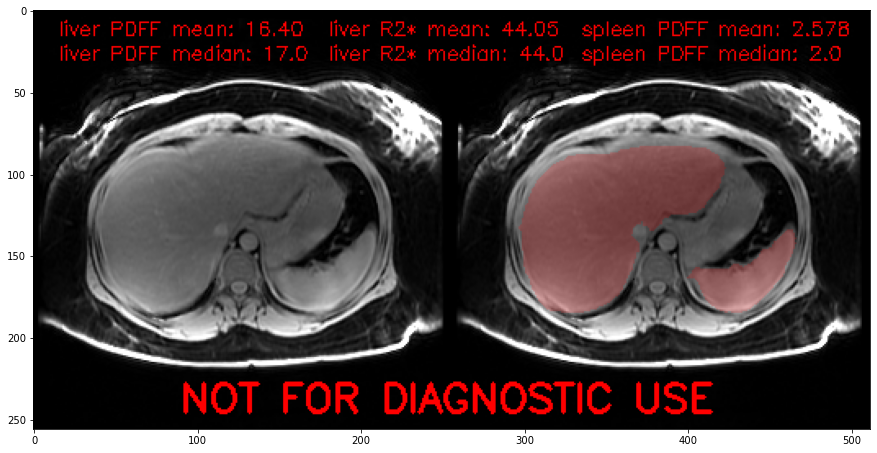

In [27]:
plt.figure(figsize = (15,15))
plt.imshow(text_img[30,:,:,:])
plt.show

In [37]:
''' Create .nii file for example ''' 

text_nii = nib.Nifti1Image(text_ni, mag_ni.affine)
nib.save(text_nii, 'test_text.nii')

In [38]:
''' Create PNG image for example '''

text_img = np.moveaxis(text_img,0,2)
data = im.fromarray(text_img[:,:,30,:])
data.save('test.png')